In [99]:
%reload_ext jupyter-rdfify

In [100]:
# This cell defines some helpers, imports and strings for tests. Run it!
from rdflib import URIRef, BNode, Literal, XSD, RDF, RDFS

ex = "http://example.org/#"
triple = "({}, {}, {})"
error_not_contain = "Your graph does not contain the triple:\n{}."
error_blank_node = "The subject of the triple {} should be a blank node but it is {}"
error_multiple = "Your graph contains multiple triples of the form {}."

def get_uri(prefix, name):
    '''
    Helper function to create a URIRef from a prefix and a name.
    
    Pameters
    --------
    prefix: str
        The prefix of the URIRef
    name: str
        The name of the URIRef
    
    Returns
    -------
    URIRef
        The URIRef with the given prefix and name
    '''
    return URIRef(ex+name)

def to_string(node):
    '''
    Helper function to create a string representation of a node.

    Parameters
    ----------
    node: rdflib.term.Node
        The node to create a string representation for

    Returns
    -------
    str
        The string representation of the node
    '''
    if isinstance(node, BNode):
        return "blank node"
    else:
        return node.n3()

def contain_check(graph, subject, predicate, object):
    '''
    Helper function to check if a graph contains a triple.

    Parameters
    ----------
    graph: rdflib.graph.Graph
        The graph to check
    subject: rdflib.term.Node
        The subject of the triple
    predicate: rdflib.term.Node
        The predicate of the triple
    object: rdflib.term.Node
        The object of the triple

    Returns
    -------
    bool
        True if the graph contains the triple, False otherwise
    '''
    assert (subject,predicate,object) in graph, error_not_contain.format(triple.format(to_string(subject), to_string(predicate), to_string(object)))

The cell below defines some prefixes which you can and should use throughout the entire notebook. Run it!

In [101]:
%%rdf turtle -p

PREFIX ex: <http://example.org/#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

Turtle: Stored prefix.


# Vocabularies/Ontologies and Data Modelling

Up to now, all our graphs had very little meaning and could only be understood by humans. This is because we introduced new URIs for concepts and relationships (e.g. ex:capital or ex:Germany) but didn't formally describe them. This makes inferencing and finding similar or associated information difficult. To formally conceptualize our information, we need specialized vocabularies. These vocabularies called ontologies, provide terms with an agreed upon meaning together with rules and restrictions. Except some meta-ontologies, most ontologies model a specific topic and should only be used in that domain.  
Some problems that can be solved using such vocabularies are for example different URIs describing the same resource or a property implying another property.

In this exercise we will take a look at some core ontologies and learn to write our own ontologies.

## Task 1: RDF Vocabulary [4 points]

RDF is not only a data model but it also defines some URIs for basic data modelling. We already learned of **rdf:type**, which is a very important property expressing the membership of an object to a specified class. But it also introduces some other properties and classes important for data modelling.

### Reification

Adding facts to a graph is very simple but what if we want to add a statement which may not be true? For this we need to treat a triple as an object itself. For example if the butler accuses the gardener of being the murderer, we can't just add the fact:

**ex:Gardener a ex:Murderer .**

as we do not know if the butler tells the truth. But we can reify this triple to make it a statement said by the butler using the properties **rdf:subject, rdf:predicate, rdf:object** and the class **rdf:Statement** which are all terms defined by RDF:

**ex:Butler ex:said \[  
&nbsp;&nbsp;&nbsp;&nbsp;rdf:subject ex:Gardener ;  
&nbsp;&nbsp;&nbsp;&nbsp;rdf:predicate rdf:type ;  
&nbsp;&nbsp;&nbsp;&nbsp;rdf:object ex:Murderer ;  
&nbsp;&nbsp;&nbsp;&nbsp;a rdf:Statement ;  
] .**

**Note: The rdf:type abbreviation "a" can only be used at predicate position. At other positions use rdf:type.**

### 1a) Gossip [2 points]

A group of friends gossiped. Bob said something interesting: He said that Eve heard that Mallory cheated on Oscar.

Use nested reification to create a graph of Bob's statement.

Use the following URIs:  
Bob: **http://example.org/#Bob**  
Eve: **http://example.org/#Eve**  
Mallory: **http://example.org/#Mallory**  
Oscar: **http://example.org/#Oscar**  
said: **http://example.org/#said**  
heard: **http://example.org/#heard**  
cheated on: **http://example.org/#cheatedOn**  

You may also use all terms from the RDF vocabulary.

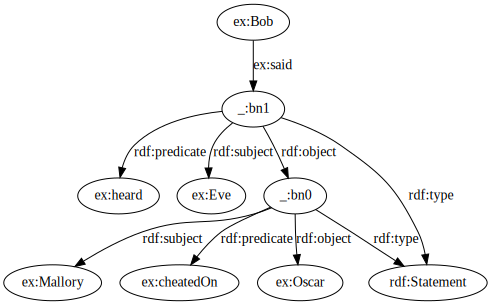

In [102]:
%%rdf turtle -l gossip

ex:Bob ex:said [
    rdf:subject ex:Eve ;
    rdf:predicate ex:heard ;
    rdf:object [
        rdf:subject ex:Mallory ;
        rdf:predicate ex:cheatedOn ;
        rdf:object ex:Oscar ;
        a rdf:Statement ;
    ] ;
    a rdf:Statement ;
] .

In [103]:
# This test will check whether your graph contains a statement by Bob. [0.5 points]
store = %rdf -r
graph = store['rdfgraphs']['gossip']

res = None
res = list(graph.objects(subject=get_uri(ex, "Bob"), predicate=get_uri(ex, "said")))
sta = triple.format(ex+"Bob", ex+"said", "Blank node")

assert len(res) > 0, error_not_contain.format(sta)
assert len(res) <= 1, error_multiple.format(sta)
assert isinstance(res[0], BNode), error_blank_node.format(sta,res[0].n3())

In [104]:
# This test will check whether a statement in your graph is about what Eve heard. [0.5 points]
store = %rdf -r
graph = store['rdfgraphs']['gossip']

res1,res2 = (None, None)

res1 = list(graph.subjects(object=get_uri(ex, "Eve"), predicate=RDF.subject))
res2 = list(graph.subjects(object=get_uri(ex, "heard"), predicate=RDF.predicate))

sta1 = triple.format("Blank node", RDF.subject, ex+"Eve")
sta2 = triple.format("Blank node", RDF.predicate, ex+"heard")

assert len(res1) > 0, error_not_contain.format(sta1)
assert len(res1) <= 1, error_multiple.format(sta1)
assert isinstance(res1[0], BNode), error_blank_node.format(sta1, res1[0].n3())

assert len(res2) > 0, error_not_contain.format(sta2)
assert len(res2) <= 1, error_multiple.format(sta2)
assert isinstance(res2[0], BNode), error_blank_node.format(sta2, res2[0].n3())

In [105]:
# This test will check whether the statement of what Eve heard is correct. [1 point]
store = %rdf -r
graph = store['rdfgraphs']['gossip']

res, res2, res3 = (None, None, None)
res = list(graph.subjects(object=get_uri(ex, "Mallory"), predicate=RDF.subject))
res2 = list(graph.subjects(object=get_uri(ex, "cheatedOn"), predicate=RDF.predicate))
res3 = list(graph.subjects(object=get_uri(ex, "Oscar"), predicate=RDF.object))

triplets1 = triple.format("Blank node", RDF.subject, ex+"Mallory")
triplets2 = triple.format("Blank node", RDF.predicate, ex+"cheatedOn")
triplets3 = triple.format("Blank node", RDF.object, ex+"Oscar")

assert len(res) > 0, error_not_contain.format(triplets1)
assert len(res) <= 1, error_multiple.format(triplets1)
assert isinstance(res[0], BNode), error_blank_node.format(triplets1, res[0].n3())

assert len(res2) > 0, error_not_contain.format(triplets2)
assert len(res2) <= 1, error_multiple.format(triplets2)
assert isinstance(res2[0], BNode), error_blank_node.format(triplets2, res2[0].n3())

assert len(res3) > 0, error_not_contain.format(triplets3)
assert len(res3) <= 1, error_multiple.format(triplets3)
assert isinstance(res3[0], BNode), error_blank_node.format(triplets3, res3[0].n3())

### Primary values

When using n-ary relations, it sometimes makes sense to have a **primary value**. The address example from the second exercise sheet was an n-ary relation but none of its values (street, house number, zip code, city) could be considered primary. But when talking about the price of somethinge in a specific currency, the price could be considered primary while the currency is a complementing value. To declare a primary value in an n-ary relation, one uses the **rdf:value** property defined in the RDF vocabulary. For example if a cheeseburger costs 1 Euro, you would write:

**ex:Cheeseburger ex:price \[  
&nbsp;&nbsp;&nbsp;&nbsp;rdf:value "1" ;  
&nbsp;&nbsp;&nbsp;&nbsp;ex:currency ex:Euro ;  
\] .**

### 1b) Experiment [2 points]

Some physicists conduct an experiment to determine the gravitational acceleration.  The result of the experiment is **9.81 m/s^2** with an **uncertainty of 0.02**. Because the gravitational acceleration varies based on location, we also need to know the location which is **latitude 50.78167189752423** and **longitude 6.049597427163315**. Use an n-ary relation with primary value to model this information.

Use the following URIs:  
Experiment: **http://example.org/#Experiment**  
result: **http://example.org/#result**  
unit: **http://example.org/#unit**  
uncertainty: **http://example.org/#uncertainty**  
latitude: **http://example.org/#latitude**  
longitude: **http://example.org/#longitude**  

Use xsd:decimal as datatype for decimal values and omit the datatype for string values. You may also use all terms from the RDF vocabulary.

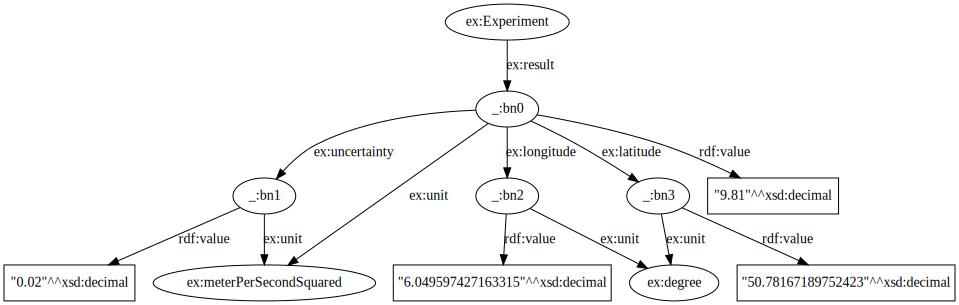

In [106]:
%%rdf turtle -l experiment

ex:Experiment ex:result [
    rdf:value "9.81"^^xsd:decimal ;
    ex:unit ex:meterPerSecondSquared ;
    ex:uncertainty [
        rdf:value "0.02"^^xsd:decimal ;
        ex:unit ex:meterPerSecondSquared ;
    ] ;
    ex:latitude [
        rdf:value "50.78167189752423"^^xsd:decimal ;
        ex:unit ex:degree ;
    ] ;
    ex:longitude [
        rdf:value "6.049597427163315"^^xsd:decimal ;
        ex:unit ex:degree ;
    ] ;
] .

In [107]:
# This test will check whether your graph contains the result of the experiment
# and whether the primary value was chosen correctly. [1 point]
store = %rdf -r
graph = store['rdfgraphs']['experiment']

res1, res2 = (None, None)
res1 = list(graph.objects(subject=get_uri(ex, "Experiment"), predicate=get_uri(ex, "result")))
res2 = list(graph.subjects(object=Literal("9.81", datatype=XSD.decimal), predicate=RDF.value))

sta1 = triple.format(ex+"Experiment", ex+"result", "Blank node")
sta2 = triple.format("Blank node", RDF.value, "9.81")

assert len(res1) > 0, error_not_contain.format(sta1)
assert len(res1) <= 1, error_multiple.format(sta1)
assert isinstance(res1[0], BNode), error_blank_node.format(sta1, res1[0].n3())

assert len(res2) > 0, error_not_contain.format(sta2)
assert len(res2) <= 1, error_multiple.format(sta2)
assert isinstance(res2[0], BNode), error_blank_node.format(sta2, res2[0].n3())

# assert both blank nodes are the same
assert res1[0] == res2[0], error_blank_node.format(sta1, res1[0].n3())

In [108]:
# This test will check whether your graph contains all complementing values. [1 point]
# Only gives points if the last test does not fail.
store = %rdf -r
graph = store['rdfgraphs']['experiment']

res1, res2 = (None, None)

res1 = list(graph.subjects(object=get_uri(ex, "meterPerSecondSquared"), predicate=get_uri(ex, "unit"))) # for result and certainty
res2 = list(graph.subjects(object=get_uri(ex, "degree"), predicate=get_uri(ex, "unit"))) # for latitude and longitude

sta1 = triple.format("Blank node", ex+"unit", ex+"meterPerSecondSquared")
sta2 = triple.format("Blank node", ex+"unit", ex+"degree")

assert len(res1) > 0, error_not_contain.format(sta1)
assert isinstance(res1[0], BNode), error_blank_node.format(sta1, res1[0].n3())

assert len(res2) > 0, error_not_contain.format(sta2)
assert isinstance(res2[0], BNode), error_blank_node.format(sta2, res2[0].n3())

## Task 2: RDF Schema [8 points]

RDF Schema (RDFS) is another [W3C recommended](https://www.w3.org/TR/rdf-schema/) vocabulary. RDFS provides means to specify characteristics of classes and properties independent of their domain. It can be seen as a weak ontology language for defining vocabularies. RDFS splits resources into three types: individuals, classes and properties. Individuals are instances of things, like a specific person or object. Classes are sets of individuals with similar properties like all persons or all cars. Properties describe individuals.

### Classes

Classes are sets of individuals with similar properties. To define our own class, we just have to declare the type of the class resource as **rdfs:Class**:

**ex:Car a rdfs:Class .**

To declare that an individual is part of a class, we also use rdf:type:

**ex:BMW a ex:Car .**

So rdfs:Class is the class containing all classes.

### Properties

As with classes, we can define our own properties to describe resources. For this, we use the class rdf:Property (Note that it is **rdf:Property** NOT rdfs:Property as it is defined in the RDF vocabulary). To define our own property, we just have to declare the type of the resource as **rdf:Property**:

**ex:drives a rdf:Property .**

Then we can use the property:

**ex:Max ex:drives ex:BMW .**

As rdf:Property is the class of all properties, it is also an rdfs:Class.

### Subclasses and Subproperties

While classes and properties are a nice way to organize resources, by themselves they do not provide means of infering new information. For this RDFS defines the two properties **rdfs:subClassOf** and **rdfs:subPropertyOf**. Any individual of a subclass also belongs to the superclass and any triple with the subproperty also holds for the superproperty. For example from the following graph:

**\# Defining classes and properties  
ex:Car a rdfs:Class .  
ex:Vehicle a rdfs:Class .  
ex:drives a rdf:Property .  
ex:operates a rdf:Property .  
\# Defining subclass- and subproperty-relations  
ex:Car rdfs:subClassOf ex:Vehicle .  
ex:drives rdfs:subPropertyOf ex:operates .  
\# Facts  
ex:BMW a ex:Car .  
ex:Max ex:drives ex:BMW .**

these triples can be inferred:

**ex:BMW a ex:Vehicle .  
ex:Max ex:operates ex:BMW .**

Both rdfs:subClassOf and rdfs:subPropertyOf are reflexive and transitive. So all \[classes/properties\] are \[subclasses/subproperties\] of themselves and when x is a \[subclass/subproperty\] of y and y is a \[subclass/subproperty\] of z then x is also a \[subclass/subproperty\] of z.

To define that two classes or properties are equal, you just add a subclass/subproperty relation in both directions:

**ex:Car rdfs:subClassOf ex:Automobile .  
ex:Automobile rdfs:subClassOf ex:Car .  
ex:drives rdfs:subPropertyOf ex:Steers .  
ex:Steers rdfs:subPropertyOf ex:drives .**

RDFS defines a class rdfs:Resource, which is the superclass of all classes.

### Domains and Ranges

Another way to infer new information is by using property domains and ranges. The domain of a property defines the class of the subject in a triple and the range the class of the object. For this we use the properties **rdfs:domain** and **rdfs:range**. For example, given the graph:

**ex:Car a rdfs:Class .  
ex:Person a rdfs:Class .  
ex:drives a rdf:Property .  
ex:drives rdfs:domain ex:Person .  
ex:drives rdfs:range ex:Car .  
ex:Max ex:drives ex:BMW .**

we can infer the triples:

**ex:Max a ex:Person .  
ex:BMW a ex:Car .**

Because ex:drives has the domain ex:Person and range ex:Car, ex:Max, who appears as subject of ex:drives, has to be a ex:Person, and ex:BMW, which appears as object of ex:drives, has to be a ex:Car.

Many RDFS properties have predefined domains and ranges. For example rdfs:domain and rdfs:range themselves have rdf:Property as a domain and rdfs:Class as range. This means that we can omit the first three triples in the example above as they can be inferred by the fourth and fifth triple.

Be careful when using multiple domains and ranges as they apply conjunctively and not disjunctively. For example:

**ex:drives rdfs:range ex:Car .  
ex:drives rdfs:range ex:Ship .**

One would think that this means that the object of ex:drives is either a car or a ship but it means that its object is a car and a ship at the same time which is probably unintended. A better way to model this would be the following:

**ex:Car rdfs:subClassOf ex:Vehicle .  
ex:Ship rdfs:subClassOf ex:Vehicle .  
ex:drives rdfs:range ex:Vehicle .**

### Comparison to Object-Oriented Programming

One may compare the class and property system of RDFS to object-oriented programming but this can be misleading. In oop, one defines classes in terms of what properties they have, while in RDFS one defines properties in terms of which classes of instances they apply to. So instead of saying: "x belongs to class y so it has to have property z", we say "Property z is used with x, so x has to belong to class y".


### Other Useful Properties

RDFS also defines the following useful properties:

**rdfs:label**: Specifies a human-readable label for a resource. We already used this in prior exercises to give resources literal names.

**rdfs:comment**: Specifies a human-readable description for a resource.

**rdfs:seeAlso**: Specifies a generic link. Useful for linking resources to similar resources or resources that provide additional information.

**rdfs:isDefinedBy**: Relate a resource to its definition. Can be used to indicate a vocabulary in which the resource is defined.

### Entailment

Using the RDFS vocabulary and its rules, we can now rdfs-entail a graph. If a graph A rdfs-entails a graph B, every rdfs-interpretation which satisfies graph A also satisfies graph B. With this we can implicitly deduct semantics for our graphs instead of explicitly specifying the meaning of information. For example, we can describe 'what a car is' without using attributes describing it. We implicitly specify it by stating that a car is a vehicle and that vehicles can be driven. Using this, we can give a machine interpretable meaning to resources and provide a more general description. RDFS-Entailment is only one of many possible entailment regimes. For more information on RDFS-Entailment, other entailment regimes and rdf semantics in general please consult this [W3C recommendation](https://www.w3.org/TR/rdf11-mt/).

### 2a) Pets [4 points]

Model the following information using the RDFS vocabulary:  
All mammals are animals. All Humans, Canines and Felines are mammals. All dogs and foxes are Canines. Only humans have pets (http://example.org/#hasPet). Having a dog (http://example.org/#hasDog) means having a pet which is a dog.

Also add that Max has a Dog with the name (rdfs:label) "Spike" and the description (rdfs:comment) "A gray bulldog. He likes to chase cats.".

Use the following URIs:  
Animals: **http://example.org/#Animal**  
Mammals: **http://example.org/#Mammal**  
Humans: **http://example.org/#Human**  
Canines: **http://example.org/#Canine**  
Felines: **http://example.org/#Feline**  
Dogs: **http://example.org/#Dog**  
Foxes: **http://example.org/#Fox**  
Has a pet: **http://example.org/#hasPet**  
Has a dog: **http://example.org/#hasDog**  
Max: **http://example.org/#Max**  
Spike: **http://example.org/#Spike**

You may also use all terms from the RDF and RDFS vocabularies. You may omit or keep as many triples as long as the rdfs-entailment closure stays the same.

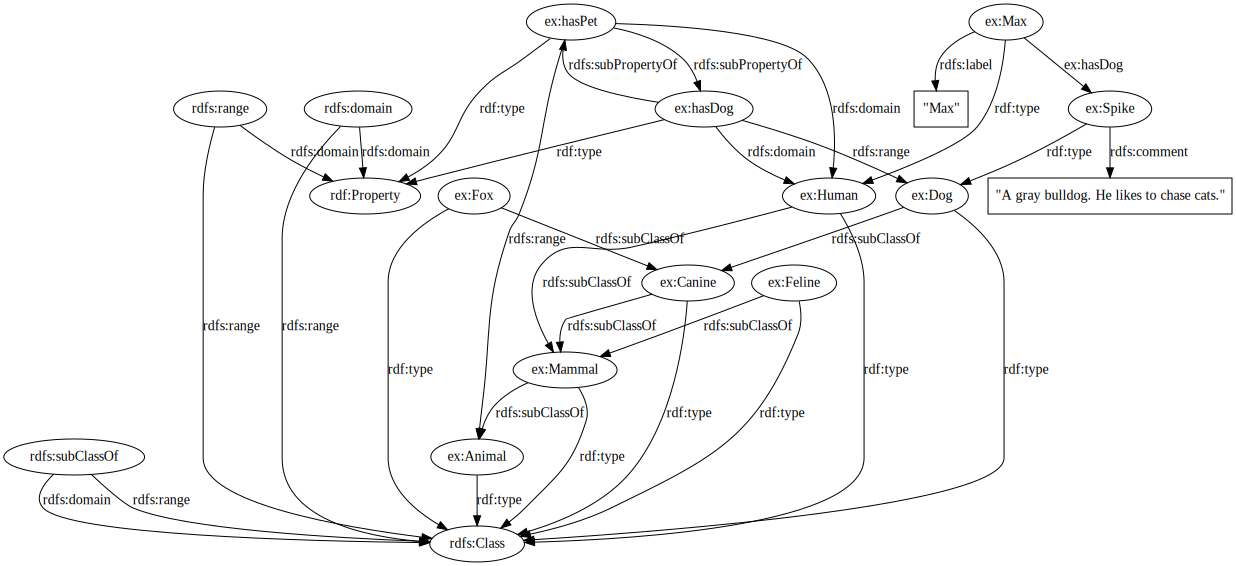

In [109]:
%%rdf turtle -l pets

# These are just some axiomatic triples. Do not remove them.
rdfs:subClassOf rdfs:domain rdfs:Class .
rdfs:subClassOf rdfs:range rdfs:Class .
rdfs:range rdfs:range rdfs:Class .
rdfs:range rdfs:domain rdf:Property .
rdfs:domain rdfs:range rdfs:Class .
rdfs:domain rdfs:domain rdf:Property .

# main class
ex:Animal a rdfs:Class .
ex:Mammal a rdfs:Class .
ex:Human a rdfs:Class .
ex:Canine a rdfs:Class .
ex:Feline a rdfs:Class .
ex:Dog a rdfs:Class .
ex:Fox a rdfs:Class .

# sub class
ex:Mammal rdfs:subClassOf ex:Animal .
ex:Human rdfs:subClassOf ex:Mammal .
ex:Canine rdfs:subClassOf ex:Mammal .
ex:Feline rdfs:subClassOf ex:Mammal .
ex:Dog rdfs:subClassOf ex:Canine .
ex:Fox rdfs:subClassOf ex:Canine .

# properties
ex:hasPet a rdf:Property .
ex:hasDog a rdf:Property .

# sub properties
ex:hasDog rdfs:subPropertyOf ex:hasPet .
ex:hasPet rdfs:subPropertyOf ex:hasDog .

# domain and range
ex:hasPet rdfs:domain ex:Human .
ex:hasPet rdfs:range ex:Animal .
ex:hasDog rdfs:domain ex:Human .
ex:hasDog rdfs:range ex:Dog .

# individuals
ex:Spike a ex:Dog ;
    rdfs:comment "A gray bulldog. He likes to chase cats." .

ex:Max a ex:Human ;
    rdfs:label "Max" ;
    ex:hasDog ex:Spike .

The cell below will automatically compute the closure of the rdfs-entailment for your graph. The extension uses a brute-force approach and only a finite set of axiomatic triples. It also omits most axiomatic triples to make the graph less cluttered so the closure will not be complete but best-effort. Note that this graph grows quite quickly.

Graphman: Graph labelled 'pets' has been entailed using the RDFS regime.


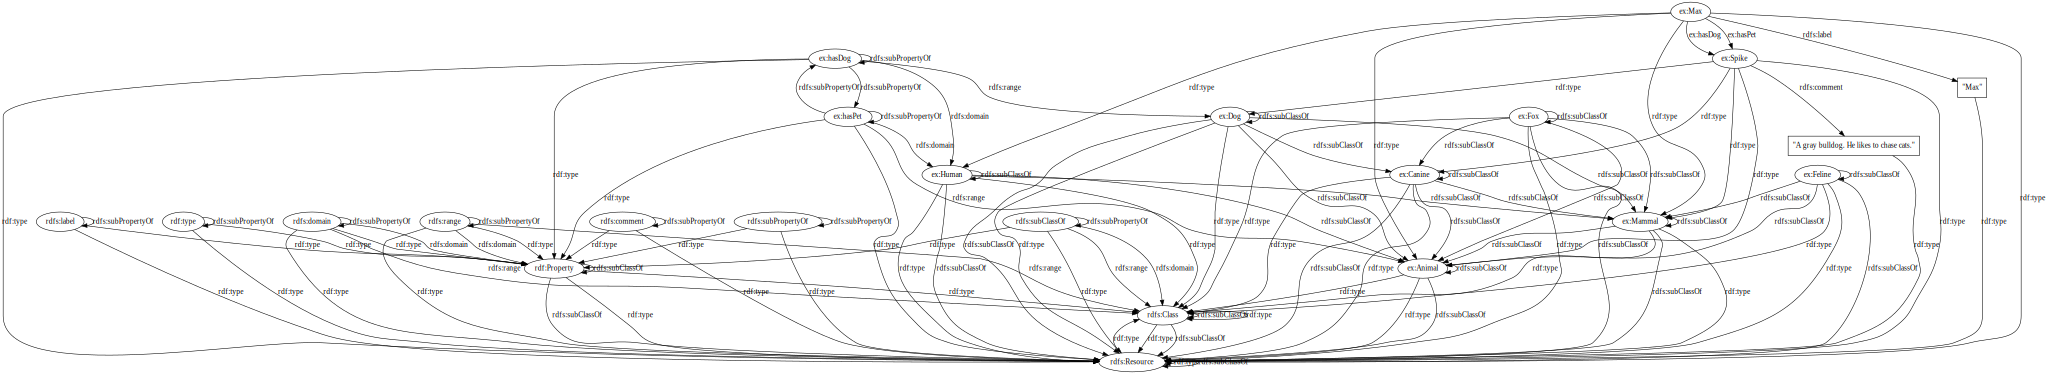

In [110]:
# This cell will compute the closure of the rdfs-entailment of your graph and draw it.
%rdf graph entail-rdfs -l pets
%rdf graph draw -l pets

In [111]:
# This test will check whether the entailment closure of your graph contains
# all necessary class and property definitions. [1 point]
%rdf graph entail-rdfs -l pets
store = %rdf -r
graph = store['rdfgraphs']['pets']

contain_check(graph, get_uri(ex, "Animal"), RDF.type, RDFS.Class)
contain_check(graph, get_uri(ex, "Mammal"), RDF.type, RDFS.Class)
contain_check(graph, get_uri(ex, "hasPet"), RDF.type, RDF.Property)

Graphman: Graph labelled 'pets' has been entailed using the RDFS regime.


In [112]:
# This test will check whether the entailment closure of your graph contains
# all necessary subclass and subproperty definitions. [1 point]
%rdf graph entail-rdfs -l pets
store = %rdf -r
graph = store['rdfgraphs']['pets']

contain_check(graph, get_uri(ex, "Mammal"), RDFS.subClassOf, get_uri(ex, "Animal"))
contain_check(graph, get_uri(ex, "Human"), RDFS.subClassOf, get_uri(ex, "Animal"))

Graphman: Graph labelled 'pets' has been entailed using the RDFS regime.


In [113]:
# This test will check whether the entailment closure of your graph contains
# all necessary range and domain definitions. [1 point]
%rdf graph entail-rdfs -l pets
store = %rdf -r
graph = store['rdfgraphs']['pets']

contain_check(graph, get_uri(ex, "hasPet"), RDFS.domain, get_uri(ex, "Human"))

Graphman: Graph labelled 'pets' has been entailed using the RDFS regime.


In [114]:
# This test will check whether the entailment closure of your graph contains
# all specified facts. [1 point]
%rdf graph entail-rdfs -l pets
store = %rdf -r
graph = store['rdfgraphs']['pets']

contain_check(graph, get_uri(ex, "Spike"), RDF.type, get_uri(ex, "Dog"))
contain_check(graph, get_uri(ex, "Spike"), RDFS.comment, Literal("A gray bulldog. He likes to chase cats."))
contain_check(graph, get_uri(ex, "Max"), RDF.type, get_uri(ex, "Human"))
contain_check(graph, get_uri(ex, "Max"), RDFS.label, Literal("Max"))
contain_check(graph, get_uri(ex, "Max"), get_uri(ex, "hasDog"), get_uri(ex, "Spike"))

Graphman: Graph labelled 'pets' has been entailed using the RDFS regime.


#### 2b) Library [4 points]

Model the following information using the RDFS vocabulary: All books and movies are mediums. The creator of a medium is a person and only mediums have a creator. Only books have an author and the author of a book is also the creator. Only mediums have titles and a publish date.

Also add that Douglas Adams is the author of a book with the title "The Hitchhiker's Guide to the Galaxy" and published "1979-10-12".

Use the following URIs:  
Medium: **http://example.org/#Medium**  
Books: **http://example.org/#Book**  
Movies: **http://example.org/#Movie**  
Persons: **http://example.org/#Person**  
creator: **http://example.org/#createdBy**  
author: **http://example.org/#authoredBy**  
title: **http://example.org/#title**  
publish date: **http://example.org/#published**  
Douglas Adams: **http://example.org/#DouglasAdams**  
The Hitchhiker's Guide to the Galaxy: **http://example.org/#HitchhikersGuide**

You may use all terms from the RDFS vocabulary. Omit datatypes of literals.

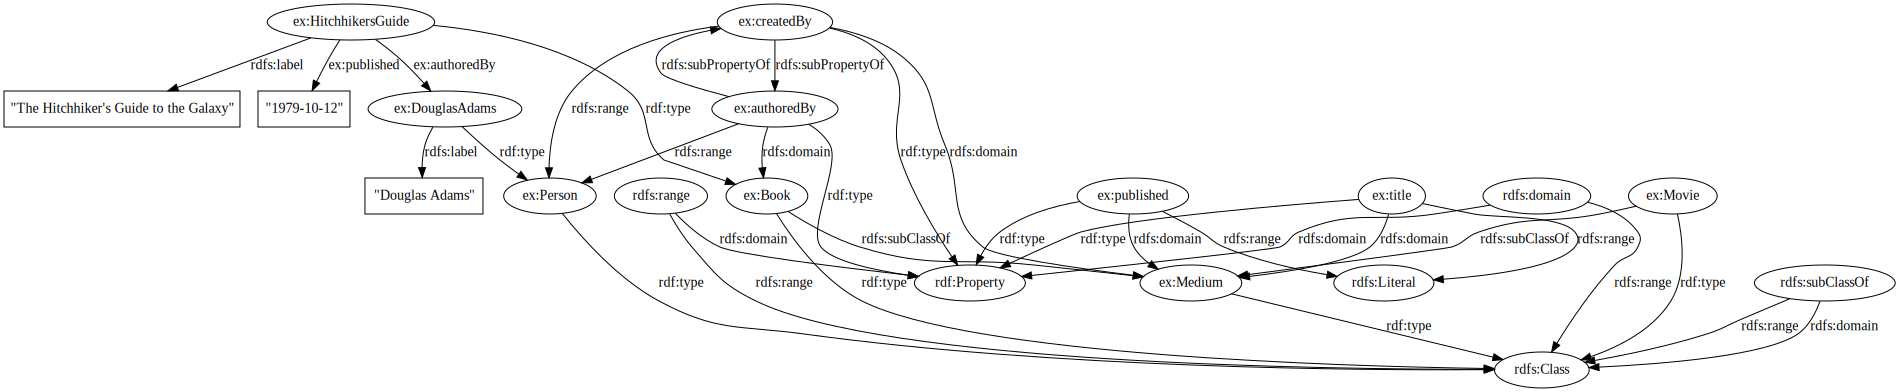

In [115]:
%%rdf turtle -l library

# These are just some axiomatic triples. Do not remove them.
rdfs:subClassOf rdfs:domain rdfs:Class .
rdfs:subClassOf rdfs:range rdfs:Class .
rdfs:range rdfs:range rdfs:Class .
rdfs:range rdfs:domain rdf:Property .
rdfs:domain rdfs:range rdfs:Class .
rdfs:domain rdfs:domain rdf:Property .

# main class
ex:Medium a rdfs:Class .
ex:Book a rdfs:Class .
ex:Movie a rdfs:Class .
ex:Person a rdfs:Class .

# sub class
ex:Book rdfs:subClassOf ex:Medium .
ex:Movie rdfs:subClassOf ex:Medium .

# properties
ex:createdBy a rdf:Property .
ex:authoredBy a rdf:Property .
ex:title a rdf:Property .
ex:published a rdf:Property .

# sub properties
ex:createdBy rdfs:subPropertyOf ex:authoredBy .
ex:authoredBy rdfs:subPropertyOf ex:createdBy .

# domain and range
ex:createdBy rdfs:domain ex:Medium .
ex:createdBy rdfs:range ex:Person .
ex:authoredBy rdfs:domain ex:Book .
ex:authoredBy rdfs:range ex:Person .
ex:title rdfs:domain ex:Medium .
ex:title rdfs:range rdfs:Literal .
ex:published rdfs:domain ex:Medium .
ex:published rdfs:range rdfs:Literal .

# individuals
ex:DouglasAdams a ex:Person ;
    rdfs:label "Douglas Adams" .

ex:HitchhikersGuide a ex:Book ;
    rdfs:label "The Hitchhiker's Guide to the Galaxy" ;
    ex:authoredBy ex:DouglasAdams ;
    ex:published "1979-10-12" .

Graphman: Graph labelled 'library' has been entailed using the RDFS regime.


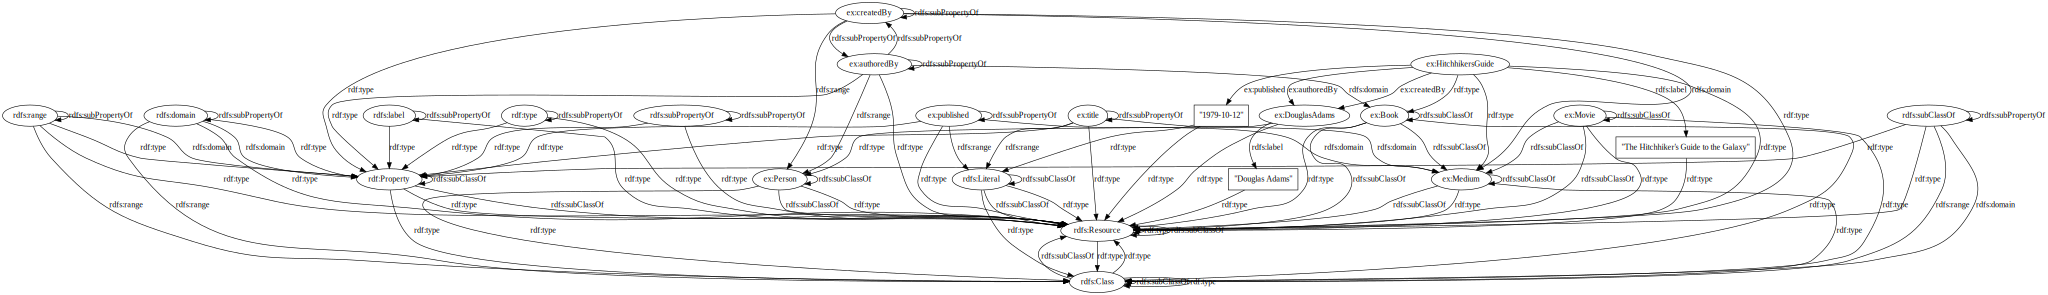

In [116]:
# This cell will compute the closure of the rdfs-entailment of your graph and draw it.
%rdf graph entail-rdfs -l library
%rdf graph draw -l library

In [117]:
# This test will check whether the entailment closure of your graph contains
# all necessary class and property definitions. [1 point]
%rdf graph entail-rdfs -l library
store = %rdf -r
graph = store['rdfgraphs']['library']

contain_check(graph, get_uri(ex, "Medium"), RDF.type, RDFS.Class)
contain_check(graph, get_uri(ex, "Book"), RDF.type, RDFS.Class)
contain_check(graph, get_uri(ex, "Movie"), RDF.type, RDFS.Class)
contain_check(graph, get_uri(ex, "Person"), RDF.type, RDFS.Class)
contain_check(graph, get_uri(ex, "createdBy"), RDF.type, RDF.Property)
contain_check(graph, get_uri(ex, "authoredBy"), RDF.type, RDF.Property)
contain_check(graph, get_uri(ex, "title"), RDF.type, RDF.Property)
contain_check(graph, get_uri(ex, "published"), RDF.type, RDF.Property)

Graphman: Graph labelled 'library' has been entailed using the RDFS regime.


In [118]:
# This test will check whether the entailment closure of your graph contains
# all necessary subclass and subproperty definitions. [1 point]
%rdf graph entail-rdfs -l library
store = %rdf -r
graph = store['rdfgraphs']['library']

contain_check(graph, get_uri(ex, "Book"), RDFS.subClassOf, get_uri(ex, "Medium"))
contain_check(graph, get_uri(ex, "Movie"), RDFS.subClassOf, get_uri(ex, "Medium"))
contain_check(graph, get_uri(ex, "createdBy"), RDFS.subPropertyOf, get_uri(ex, "authoredBy"))
contain_check(graph, get_uri(ex, "authoredBy"), RDFS.subPropertyOf, get_uri(ex, "createdBy"))

Graphman: Graph labelled 'library' has been entailed using the RDFS regime.


In [119]:
# This test will check whether the entailment closure of your graph contains
# all necessary range and domain definitions. [1 point]
%rdf graph entail-rdfs -l library
store = %rdf -r

graph = store['rdfgraphs']['library']

contain_check(graph, get_uri(ex, "createdBy"), RDFS.domain, get_uri(ex, "Medium"))
contain_check(graph, get_uri(ex, "createdBy"), RDFS.range, get_uri(ex, "Person"))
contain_check(graph, get_uri(ex, "authoredBy"), RDFS.domain, get_uri(ex, "Book"))
contain_check(graph, get_uri(ex, "authoredBy"), RDFS.range, get_uri(ex, "Person"))
contain_check(graph, get_uri(ex, "title"), RDFS.domain, get_uri(ex, "Medium"))
contain_check(graph, get_uri(ex, "title"), RDFS.range, RDFS.Literal)
contain_check(graph, get_uri(ex, "published"), RDFS.domain, get_uri(ex, "Medium"))
contain_check(graph, get_uri(ex, "published"), RDFS.range, RDFS.Literal)

Graphman: Graph labelled 'library' has been entailed using the RDFS regime.


In [120]:
# This test will check whether the entailment closure of your graph contains
# all specified facts. [1 point]
%rdf graph entail-rdfs -l library
store = %rdf -r
graph = store['rdfgraphs']['library']

contain_check(graph, get_uri(ex, "DouglasAdams"), RDF.type, get_uri(ex, "Person"))
contain_check(graph, get_uri(ex, "DouglasAdams"), RDFS.label, Literal("Douglas Adams"))
contain_check(graph, get_uri(ex, "HitchhikersGuide"), RDF.type, get_uri(ex, "Book"))
contain_check(graph, get_uri(ex, "HitchhikersGuide"), RDFS.label, Literal("The Hitchhiker's Guide to the Galaxy"))
contain_check(graph, get_uri(ex, "HitchhikersGuide"), get_uri(ex, "authoredBy"), get_uri(ex, "DouglasAdams"))
contain_check(graph, get_uri(ex, "HitchhikersGuide"), get_uri(ex, "published"), Literal("1979-10-12"))

Graphman: Graph labelled 'library' has been entailed using the RDFS regime.


## Other Vocabularies/Ontologies

We looked at the RDF and RDFS vocabularies which are both very basic, domain-independent vocabularies. There are countless more domain specific vocabularies which provide classes, properties or even individuals with agreed upon meaning. We can use these vocabularies to make our graphs easier to interpret by humans and machines. For example, above we defined the properties creator and publish date. These properties are very general and thus often used. If everyone defined their own properties, we would have many properties with the same meaning. Instead if everyone agreed to use a specific URI for specifying e.g. the creator of a resource, it would be a lot easier to work on multiple graphs with different origin. An example for such a vocabulary is the well known Dublin Core(TM) vocabulary. This vocabulary defines 15 core properties to describe resources like creator, date, title, description, format and similar. 